In [1]:
import os
import sys
sys.path.append('..\\..\\')
import pickle
from user_fun.io import read_comsol

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata

xpinn_result_file = '..\\..\\para_result\\wave-x\\test_record.pkl'
udpinn_result_file = '..\\..\\para_result\\wave-ud\\test_record.pkl'
with open(xpinn_result_file, 'rb') as file:
    xpinn_loaded_test_record = pickle.load(file)
with open(udpinn_result_file, 'rb') as file:
    udpinn_loaded_test_record = pickle.load(file)

# 设置字体样式为 Times New Roman
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 6})

import numpy as np
from scipy.interpolate import griddata

def interpolate_data(data_points, field_data, num_points_x=100, num_points_y=100):
    x_min, x_max = data_points[:, 0].min(), data_points[:, 0].max()
    y_min, y_max = data_points[:, 1].min(), data_points[:, 1].max()
    x_range = (x_min, x_max)
    y_range = (y_min, y_max)
    
    x_values = np.linspace(x_range[0], x_range[1], num_points_x)
    y_values = np.linspace(y_range[0], y_range[1], num_points_y)
    x_grid, y_grid = np.meshgrid(x_values, y_values)
    grid_points = np.vstack((x_grid.ravel(), y_grid.ravel())).T
    
    field_num = field_data.shape[1] if field_data.ndim > 1 else 1
    
    interpolated_field_data_list = []
    for i in range(field_num):
        cubic_interpolated_field_data = griddata(data_points, field_data[:, i], grid_points, method='cubic')
        nearest_interpolated_field_data = griddata(data_points, field_data[:, i], grid_points, method='nearest')
        
        # Replace NaN values with nearest interpolation results
        interpolated_field_data = np.where(np.isnan(cubic_interpolated_field_data), nearest_interpolated_field_data, cubic_interpolated_field_data)
        
        interpolated_field_data_list.append(interpolated_field_data)
    
    interpolated_field_data = np.stack(interpolated_field_data_list, axis=1)
    return grid_points, interpolated_field_data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def multi_gaussian(x, peaks, sigmas):
    result = 0
    for p, s in zip(peaks, sigmas):
        result += np.exp(-((x-p)**2)/(2*s**2))
    return result

def analytical_solution(x, t, peaks, sigmas):
    return multi_gaussian(t - x / 3, peaks, sigmas)

peaks = [0.2, 0.4, 0.7]
sigmas = [0.05, 0.05, 0.05]


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def multi_gaussian(x, peaks, sigmas):
    result = 0
    for p, s in zip(peaks, sigmas):
        result += np.exp(-((x-p)**2)/(2*s**2))
    return result

def analytical_solution(x, t, peaks, sigmas):
    return multi_gaussian(t - x / 3, peaks, sigmas)

peaks = [0.2, 0.4, 0.7]
sigmas = [0.05, 0.05, 0.05]

def compute_actual_data(data_points, peaks, sigmas):
    x_range = data_points[:, 1]
    t = data_points[:, 0]
    actual_data = analytical_solution(x_range, t, peaks, sigmas).reshape(-1)
    return actual_data



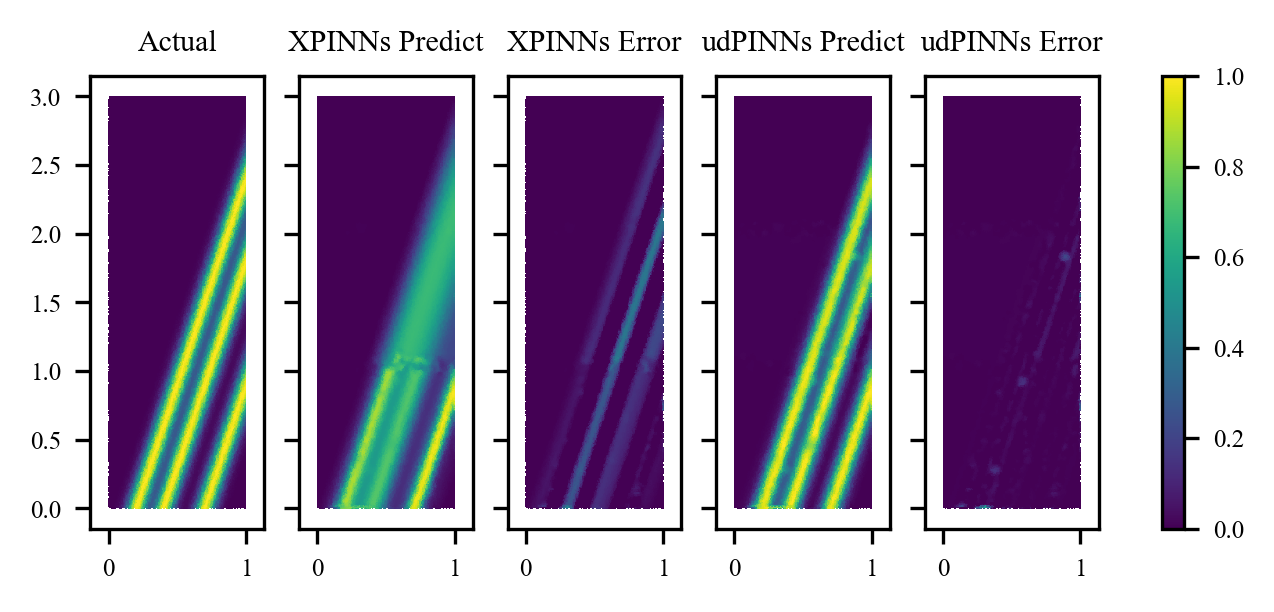

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_actual_predicted(ax, data_points, field_data, title, cmap='viridis', vmin=None, vmax=None):
    x = data_points[:, 0]
    y = data_points[:, 1]
    z = field_data
    triang = tri.Triangulation(x, y)
    im = ax.tripcolor(triang, z.flatten(), cmap=cmap, vmin=vmin, vmax=vmax)  # Flatten the array before plotting
    ax.set_title(title)
    ax.axis('equal')
    return im

def plot_2d_wave_solution(data_points, actual_data, xpinn_result, xpinn_error, udpinn_result, udpinn_error):
    fig = plt.figure(figsize=(4.72, 2), dpi=300)
    vmin = np.min(actual_data)
    vmax = np.max(actual_data)

    ax1 = plt.subplot(1, 5, 1)
    im1 = plot_actual_predicted(ax1, data_points, actual_data, 'Actual', vmin=vmin, vmax=vmax)

    ax2 = plt.subplot(1, 5, 2)
    im2 = plot_actual_predicted(ax2, data_points, xpinn_result, 'XPINNs Predict', vmin=vmin, vmax=vmax)
    plt.tick_params('y', labelleft=False)

    ax3 = plt.subplot(1, 5, 3)
    im3 = plot_actual_predicted(ax3, data_points, xpinn_error, 'XPINNs Error', vmin=vmin, vmax=vmax)
    plt.tick_params('y', labelleft=False)

    ax4 = plt.subplot(1, 5, 4)
    im4 = plot_actual_predicted(ax4, data_points, udpinn_result, 'udPINNs Predict', vmin=vmin, vmax=vmax)
    plt.tick_params('y', labelleft=False)

    ax5 = plt.subplot(1, 5, 5)
    im5 = plot_actual_predicted(ax5, data_points, udpinn_error, 'udPINNs Error', vmin=vmin, vmax=vmax)
    plt.tick_params('y', labelleft=False)

    axes = [ax1, ax2, ax3, ax4, ax5]

    fig.subplots_adjust(left=0.1, right=0.99, wspace=0.2, hspace=0.4)

    fig.colorbar(im1, ax=axes)
    fig.savefig("wave-1.png", dpi=300, facecolor='white')
    plt.show()

xpinn_points = xpinn_loaded_test_record[99][0]
xpinn_field = xpinn_loaded_test_record[99][1]
ex_xpinn_points, ex_xpinn_field = interpolate_data(xpinn_points, xpinn_field, num_points_y=300)
actual_data = compute_actual_data(ex_xpinn_points, peaks, sigmas)[:, np.newaxis]

udpinn_points = udpinn_loaded_test_record[99][0]
udpinn_field = udpinn_loaded_test_record[99][1]
ex_udpinn_points, ex_udpinn_field = interpolate_data(udpinn_points, udpinn_field, num_points_y=300)

plot_2d_wave_solution(ex_xpinn_points, actual_data,
                      ex_xpinn_field, ex_xpinn_field-actual_data,
                      ex_udpinn_field, ex_udpinn_field-actual_data)


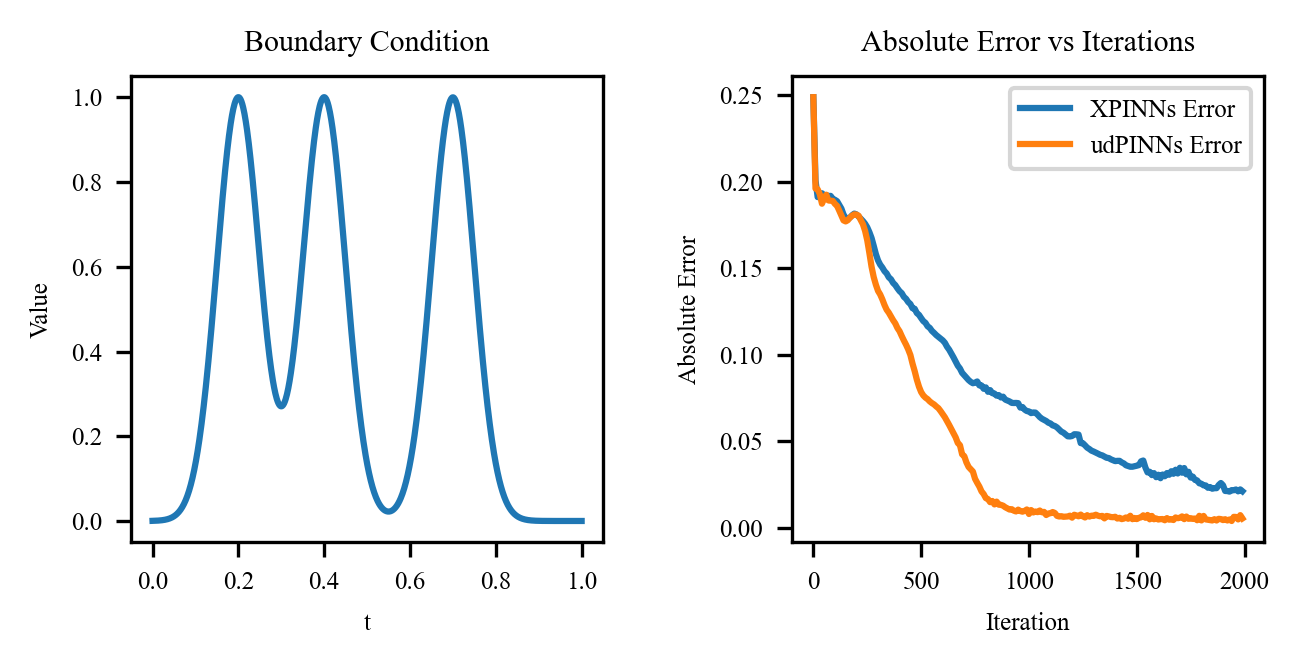

In [16]:
import matplotlib.pyplot as plt

def plot_boundary_and_error(xpinn_loaded_test_record, udpinn_loaded_test_record, peaks, sigmas):
    x = np.linspace(0, 1, 1000)
    boundary_data = multi_gaussian(x, peaks, sigmas)
    
    xpinn_errors = []
    udpinn_errors = []

    for i in range(len(xpinn_loaded_test_record)):
        xpinn_points = xpinn_loaded_test_record[i][0]
        xpinn_field = xpinn_loaded_test_record[i][1]
        actual_data = compute_actual_data(xpinn_points, peaks, sigmas)[:, np.newaxis]
        xpinn_errors.append(np.mean(np.abs(actual_data - xpinn_field)))
        
        udpinn_points = udpinn_loaded_test_record[i][0]
        udpinn_field = udpinn_loaded_test_record[i][1]
        actual_data = compute_actual_data(udpinn_points, peaks, sigmas)[:, np.newaxis]
        udpinn_errors.append(np.mean(np.abs(actual_data - udpinn_field)))

    fig, axes = plt.subplots(1, 2, figsize=(4.72, 2.2), dpi=300)
    
    axes[0].plot(x, boundary_data)
    axes[0].set_title('Boundary Condition')
    axes[0].set_xlabel('t')
    axes[0].set_ylabel('Value')

    iter = np.arange(0,200,1)*10
    axes[1].plot(iter, xpinn_errors, label='XPINNs Error', linestyle='-')
    axes[1].plot(iter, udpinn_errors, label='udPINNs Error', linestyle='-')
    axes[1].set_title('Absolute Error vs Iterations')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Absolute Error')
    axes[1].legend()

    plt.tight_layout()
    fig.subplots_adjust(left=0.1, right=0.9, wspace=0.4, hspace=0.4)
    fig.savefig("wave-2.png", dpi=300, facecolor='white', pad_inches = 0)

    plt.show()

plot_boundary_and_error(xpinn_loaded_test_record, udpinn_loaded_test_record, peaks, sigmas)
